In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error


In [2]:
df = pd.read_csv("dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


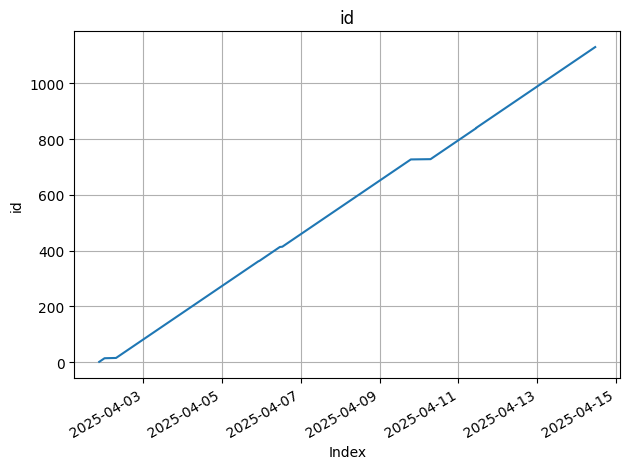

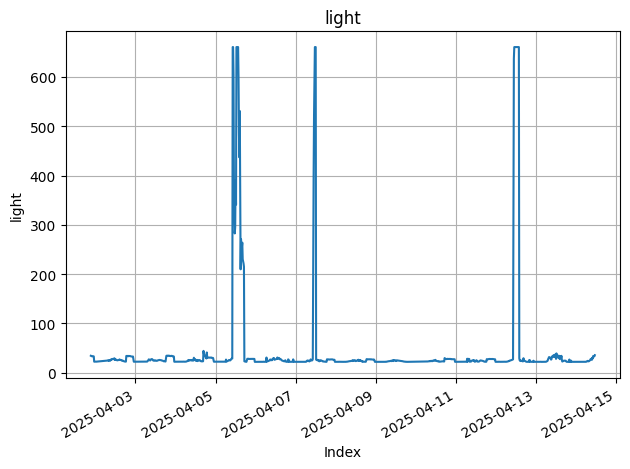

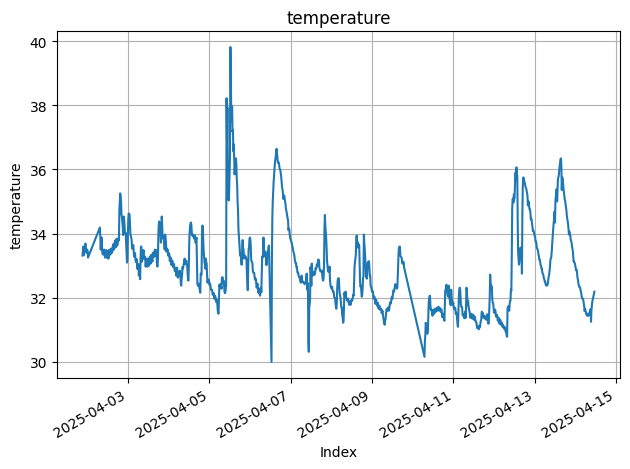

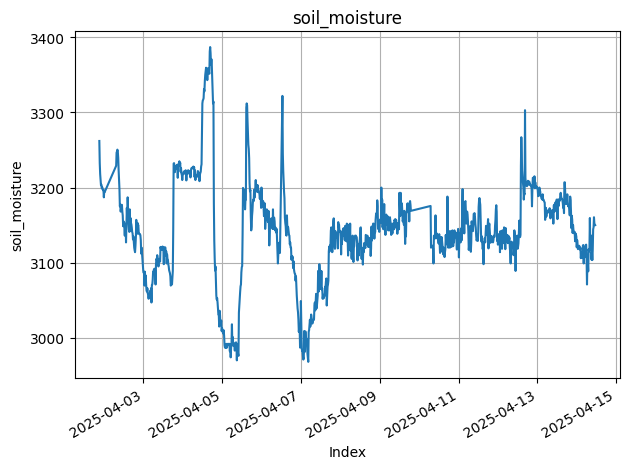

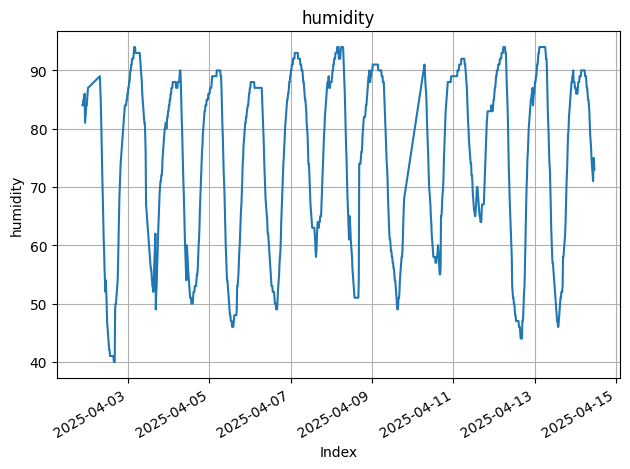

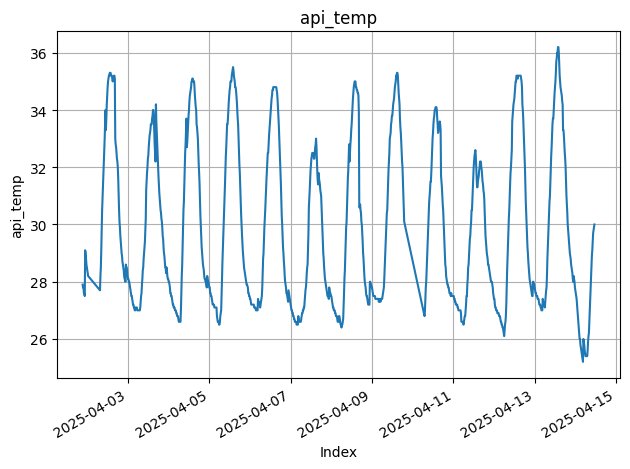

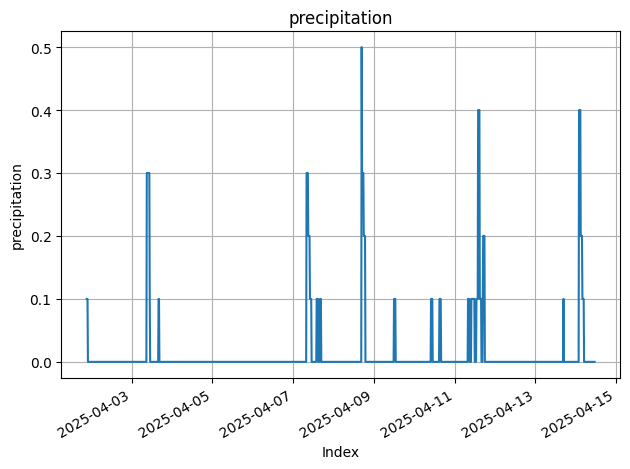

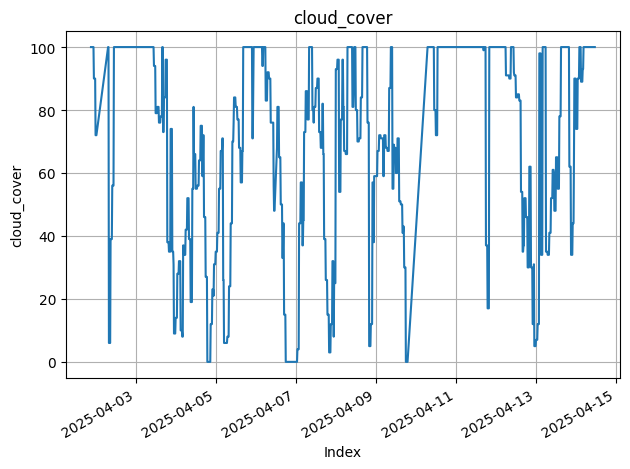

In [3]:
for column in df.columns:
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

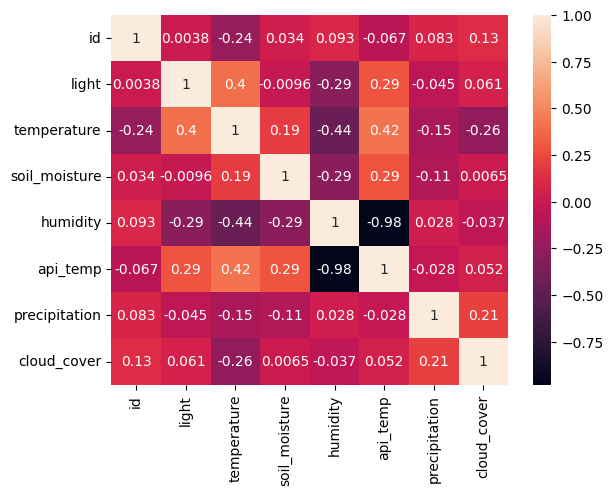

In [4]:
sns.heatmap(df.corr(),annot=True)

# EDA

In [5]:
df["soil_moisture"].diff().dropna()

ts
2025-04-01 21:30:00   -29.5
2025-04-01 21:45:00   -14.5
2025-04-01 22:00:00    -7.0
2025-04-01 22:15:00    -8.0
2025-04-01 22:30:00     1.0
                       ... 
2025-04-14 10:15:00     2.5
2025-04-14 10:30:00    13.5
2025-04-14 10:45:00    -8.5
2025-04-14 11:00:00    -1.0
2025-04-14 11:15:00    -1.0
Name: soil_moisture, Length: 1129, dtype: float64

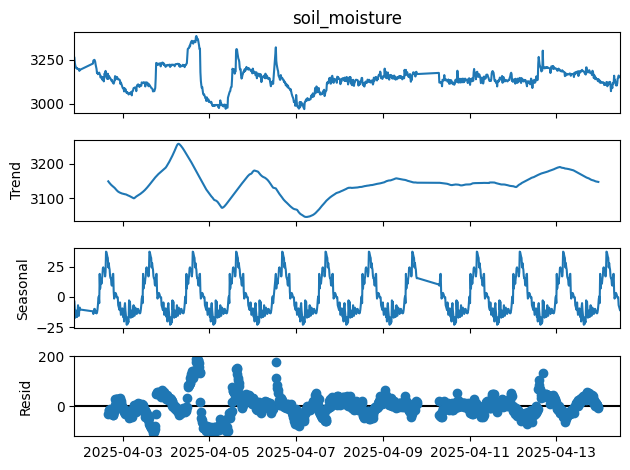

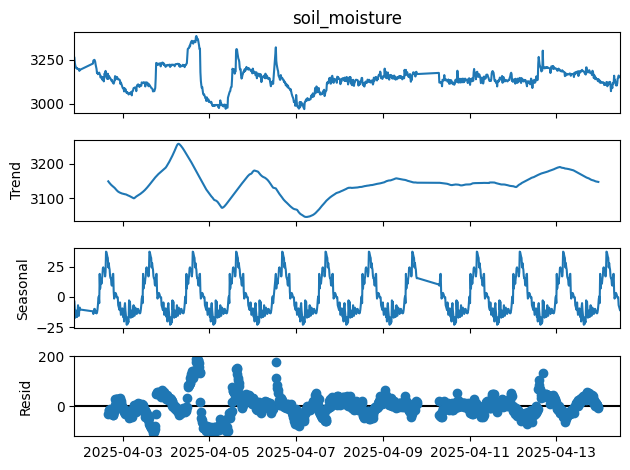

In [6]:
seasonal_decompose(df["soil_moisture"], model="additive", period=96).plot()


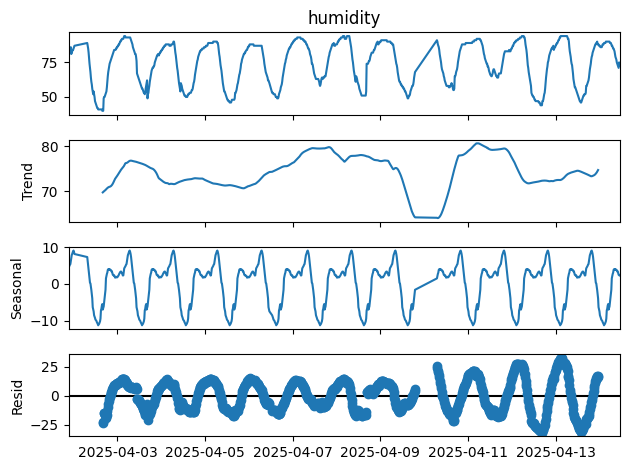

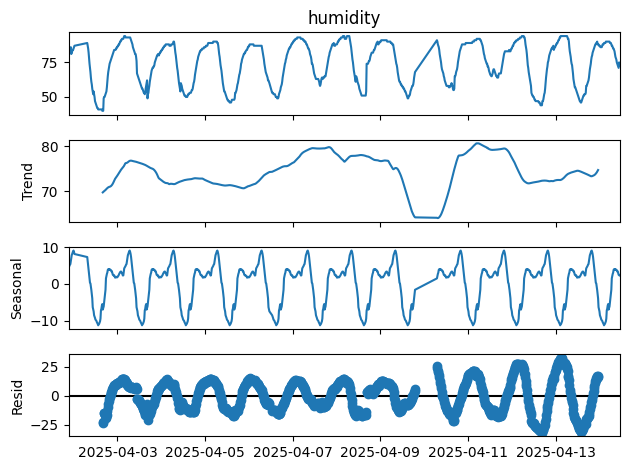

In [7]:
seasonal_decompose(df["humidity"], model="additive", period=96).plot()

## Find D parameter

In [8]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -3.84682253492801
p-value: 0.0024629935755944216
Critial Values:
   1%, -3.4361604996756685
Critial Values:
   5%, -2.864105678204421
Critial Values:
   10%, -2.568136037454102


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

<BarContainer object of 25 artists>

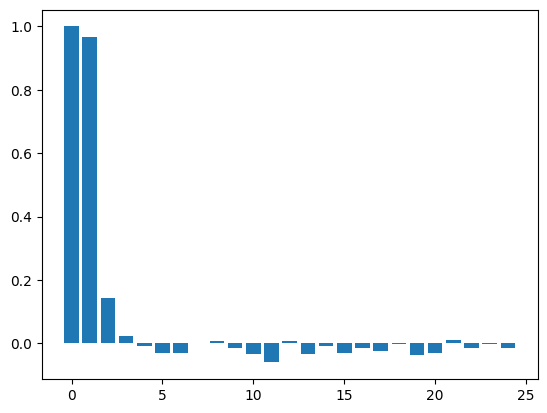

In [9]:
# I believe 2 or 3 is the variable for the term AR in order
pacf_vals = pacf(df["soil_moisture"])
# where did 25 came from?
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

There are 2 exceptionally high bars, therefore, p=2

## Find Q parameter

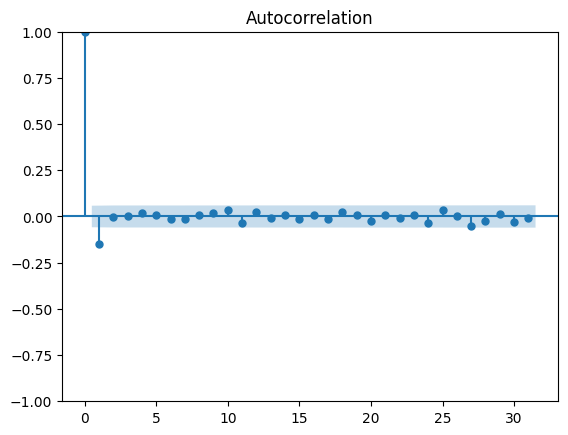

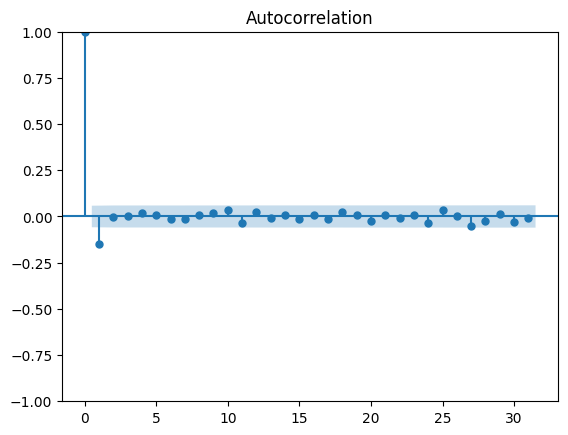

In [10]:
plot_acf(df["soil_moisture"].diff().dropna())

## Separate the test and train data

In [11]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]

In [12]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [13]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09 00:00:00,651,22.0622,32.1875,3155.0,90,27.8,0.0,59
2025-04-09 00:15:00,652,21.9617,32.2188,3157.5,90,27.7,0.0,59
2025-04-09 00:30:00,653,22.0118,32.1875,3155.0,91,27.6,0.0,59
2025-04-09 00:45:00,654,22.0118,32.1094,3153.0,91,27.5,0.0,59
2025-04-09 01:00:00,655,22.0118,31.9688,3200.0,91,27.5,0.0,67


In [14]:
train_data[["soil_moisture"]]

,soil_moisture
ts,
2025-04-01 21:15:00,3262.0
2025-04-01 21:30:00,3232.5
2025-04-01 21:45:00,3218.0
2025-04-01 22:00:00,3211.0
2025-04-01 22:15:00,3203.0
...,...
2025-04-08 23:00:00,3145.0
2025-04-08 23:15:00,3150.5
2025-04-08 23:30:00,3147.0


wtf?

In [15]:
test_data['soil_moisture'].count()



146

## Train the model

In [16]:
model = SARIMAX(
    endog=test_data['soil_moisture'],
    exog=test_data[['temperature']],  # Use DataFrame/Series, not column name
    order=(2,0,0)
)
results = model.fit()
results.summary()

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                  146
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -707.743
Date:                Fri, 18 Apr 2025   AIC                           1423.485
Time:                        15:33:33   BIC                           1435.420
Sample:                             0   HQIC                          1428.334
                                - 146                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    98.3396      0.694    141.695      0.000      96.979      99.700
ar.L1           0.6912      0.088      7.839      0.000       0.518       0.864
ar.L2           0.1468      0.100      1.466      0.143      -0.049       0.343
sigma2        943.5107     43.603     21.638      0.000     858.050    1028.972
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9364.64
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             4.38
Prob(H) (two-sided):                  0.65   Kurtosis:                        41.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
prediction = pd.DataFrame(results.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
prediction.columns = ['predicted']
prediction

,predicted
ts,
2025-04-09 00:00:00,3165.305538
2025-04-09 00:15:00,3160.034826
2025-04-09 00:30:00,3156.269947
2025-04-09 00:45:00,3148.904258
2025-04-09 01:00:00,3139.088616
...,...
2025-04-10 23:00:00,3124.942250
2025-04-10 23:15:00,3108.217621
2025-04-10 23:30:00,3126.602112


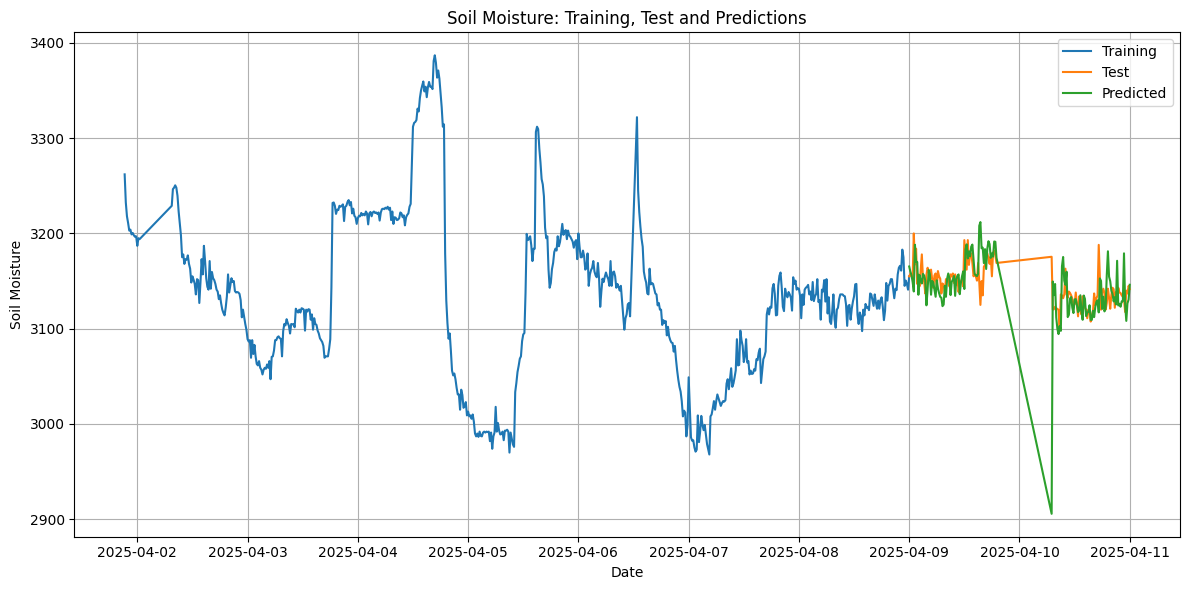

In [18]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
test_data.count()

id               146
light            146
temperature      146
soil_moisture    146
humidity         146
api_temp         146
precipitation    146
cloud_cover      146
dtype: int64

In [20]:
prediction.count()

predicted    146
dtype: int64

In [21]:
# Get the RMSE
rmse = root_mean_squared_error(test_data['soil_moisture'], prediction)
print(rmse)

30.724579139826194


## Train again for two times with 2 sets of parameters

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


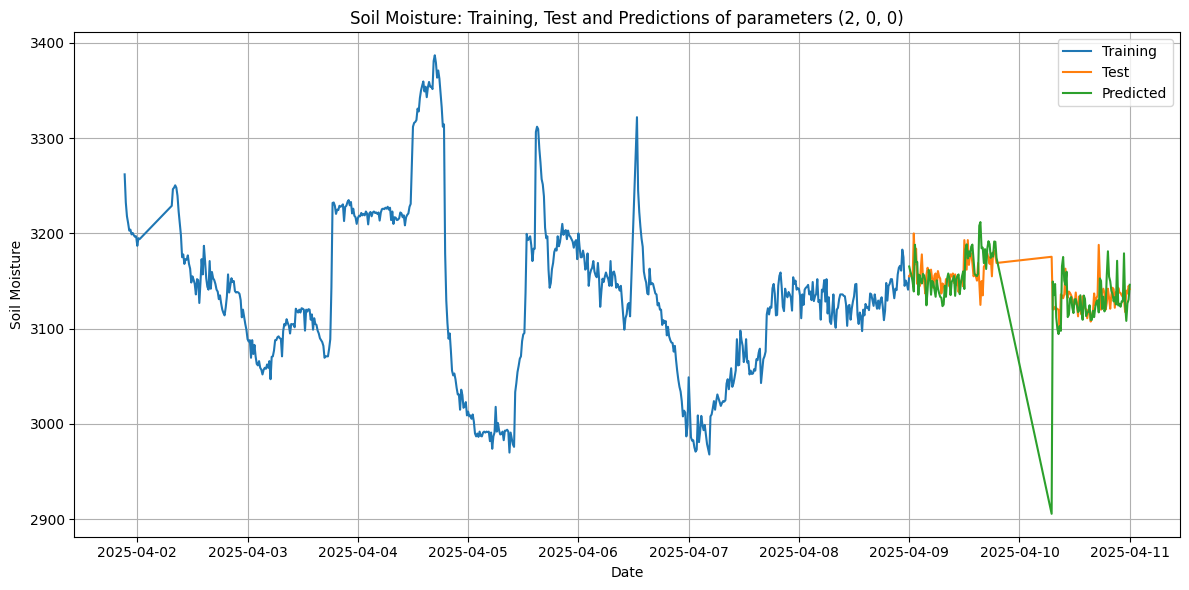

RMSE of (2, 0, 0) is :  30.724579139826194


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


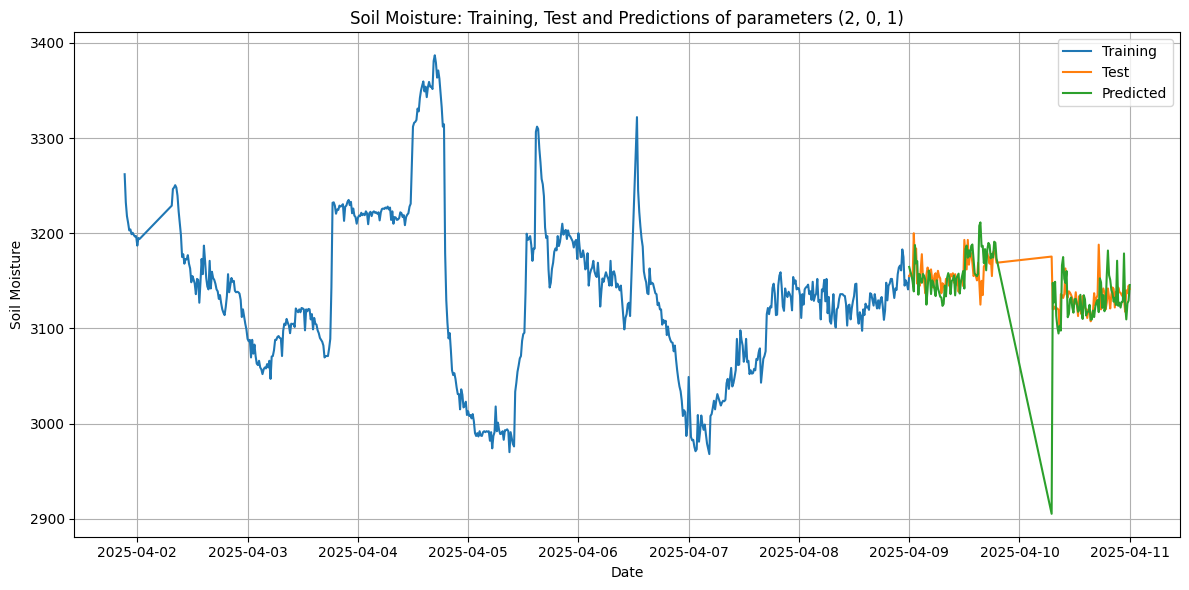

RMSE of (2, 0, 1) is :  30.717320992763845


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


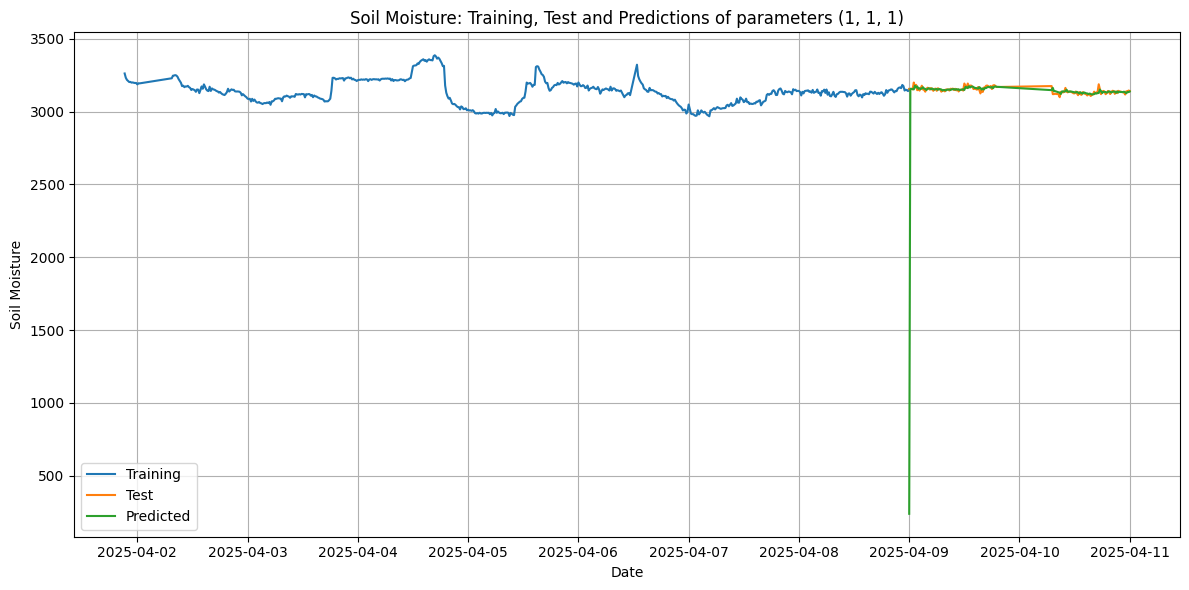

RMSE of (1, 1, 1) is :  241.72999233367065


In [22]:
parameters = [(2,0,0), (2,0,1), (1,1,1)]
for order in parameters:
    model = SARIMAX(
        endog=test_data['soil_moisture'],
        exog=test_data[['temperature']],  # Use DataFrame/Series, not column name
        order=order
    )
    results = model.fit()

    prediction = pd.DataFrame(results.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
    prediction.columns = ['predicted']

    plt.figure(figsize=(12, 6))
    # Ensure datetime index and proper plotting
    plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
    plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
    plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.title(f"Soil Moisture: Training, Test and Predictions of parameters {str(order)}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"RMSE of {order} is : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


In [23]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [24]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09 00:00:00,651,22.0622,32.1875,3155.0,90,27.8,0.0,59
2025-04-09 00:15:00,652,21.9617,32.2188,3157.5,90,27.7,0.0,59
2025-04-09 00:30:00,653,22.0118,32.1875,3155.0,91,27.6,0.0,59
2025-04-09 00:45:00,654,22.0118,32.1094,3153.0,91,27.5,0.0,59
2025-04-09 01:00:00,655,22.0118,31.9688,3200.0,91,27.5,0.0,67
